In [1]:
%matplotlib inline
import numpy as np
import scipy
import scipy.integrate

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
from pydmd import DMD

In this tutorial, importance of regularization when dealing with ill-conditioned data is highlited.
The data used here is the simulation results (the velocity field) for the wake behind a circular cylinder at Reynolds number Re = 100; Available in [the data-driven science and engineering book's website](www.databookuw.com/).

---------------------------------------------------------------------------------------------------------------------------
Here we assign the geometrical parameters of the data for displaying purposes: 
~~~~ 
"The computational domain comprises four grids that are nested so that the finest grid covers a domain of 9×4 and the largest grid covers a domain of 72×32, where lengths are nondimensionalized by the cylinder diameter; each grid contains 450 × 200 points, so that there are 50 points per cylinder diameter. We use a time step of Δt = 0.02 ... we collect
m = 150 snapshots at regular intervals in time, 10Δt, sampling five periods of vortex shedding."
~~~~


In [2]:
nx = 449
ny = 199
dt = .2
xx, yy = np.meshgrid(np.linspace(-1, 8, nx), np.linspace(-2, 2, ny))

## ------ supressing data in the cylinder region
def cylinder_clean_data(X, fill = 0):
    
    uu = X.reshape((ny, nx, -1), order = 'F')
    uu[(xx**2+yy**2)<.5**2, :] = fill
    
    return uu.reshape((ny*nx, -1), order = 'F')

def reshaping(X):
    
    return X.reshape((ny, nx), order = 'F')

cylinder_idx = (xx**2+yy**2)<.5**2

We load the data and assign it to the X matrix

In [3]:
X = np.concatenate((np.load("../data/mat_UALL_1.npy"), np.load("../data/mat_UALL_2.npy")))

We perform the DMD decomposition, without performing a svd truncation : ```svd_rank = -1```.
As expected, the bad conditioning warning shows up.

No regularization is used in this case : ```tikhonov_regularization = None``` ( See the next part)

In [4]:
dmd = DMD(svd_rank=-1, exact=True, sorted_eigs=False, tikhonov_regularization=None)
dmd.fit(X);

/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/pydmd/dmdbase.py:390: UserWarning: Input data matrix X has condition number 6505960.291991895. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


We then show the DMD modes, and we can see instable/noisy modes 

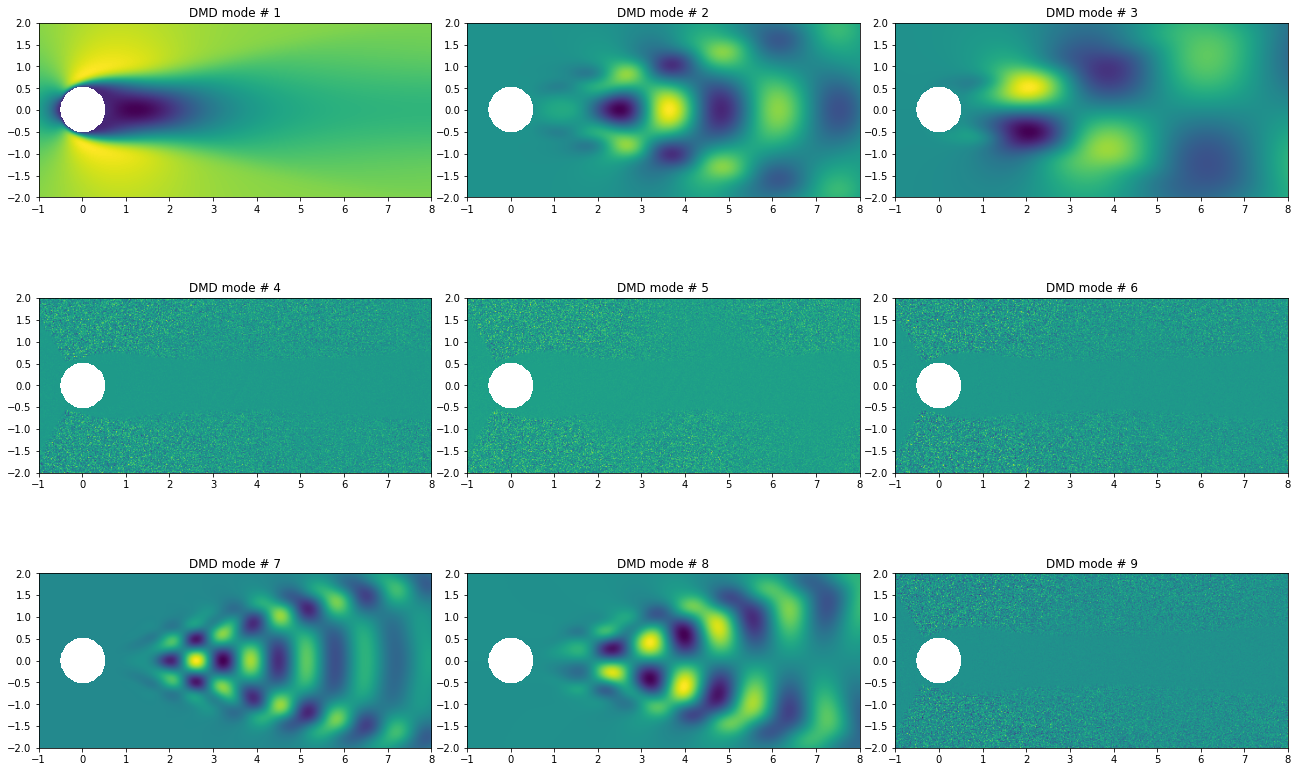

In [5]:
n_mode = np.arange(0, 18, 2)

fig, ax  = plt.subplots(3, 3, figsize = (18, 12))

for i in range(3):
    for j in range(3):
        
        to_plot = np.real(reshaping(dmd.modes[:, n_mode[((i)*3)+j]].copy()))
        to_plot[cylinder_idx] = np.nan
        im = ax[i, j].imshow(to_plot, extent=[-1, 8, -2, 2]);
        ax[i, j].set_title("DMD mode # {:d}" .format(int((n_mode[((i)*3)+j]+2)/2)));


fig.tight_layout();

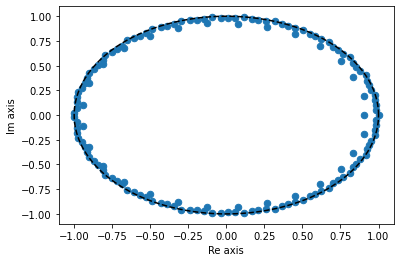

In [6]:
plt.plot(np.real(dmd.eigs), np.imag(dmd.eigs), '.', markersize = 13);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

-----------------------------------------------------------------------------------------------------------------------

**Tikhonov Regularization**

When dealing with ill-conditioned input matrices regularization methods should be used to deal with the least square problem; we are using the well-known Tikhonov regularization in our case, i.e minimizing 
$$ \|\pmb A \pmb X - \pmb Y\|^2 + \lambda \|\pmb A\|^2$$
instead of 
$$ \|\pmb A \pmb X - \pmb Y\|^2$$

Here we use ```tikhonov = 1e-8``` instead of the default ```tikhonov = 0``` (no regularization)

In [8]:
dmd = DMD(svd_rank=-1, exact=True, sorted_eigs=False, tikhonov_regularization=1e-8)
dmd.fit(X);

/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/pydmd/dmdbase.py:390: UserWarning: Input data matrix X has condition number 6505960.291991895. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


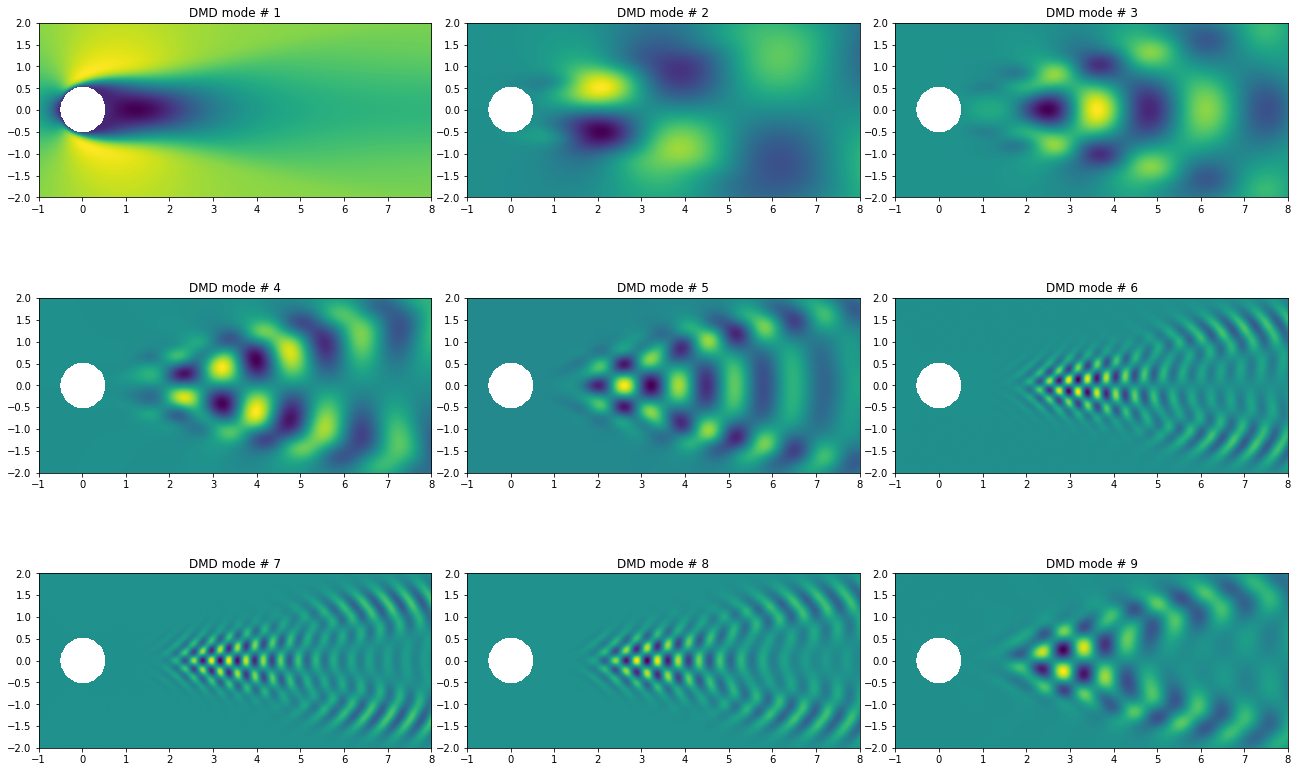

In [9]:
n_mode = np.arange(0, 18, 2)

fig, ax  = plt.subplots(3, 3, figsize = (18, 12))

for i in range(3):
    for j in range(3):
        
        to_plot = np.real(reshaping(dmd.modes[:, n_mode[((i)*3)+j]].copy()))
        to_plot[cylinder_idx] = np.nan
        im = ax[i, j].imshow(to_plot, extent=[-1, 8, -2, 2]);
        ax[i, j].set_title("DMD mode # {:d}" .format(int((n_mode[((i)*3)+j]+2)/2)));


fig.tight_layout();

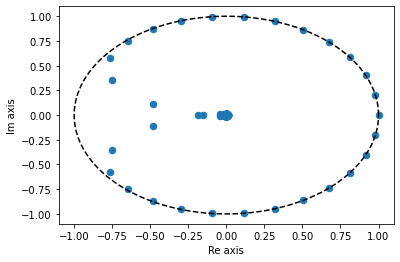

In [10]:
plt.plot(np.real(dmd.eigs), np.imag(dmd.eigs), '.', markersize = 13);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");